# ResNet

> Neural net model

In [ ]:
#| default_exp models.resnet

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch_lr_finder import LRFinder
from torchinfo import summary
from torchviz import make_dot
from torchvision.transforms import transforms


from omegaconf import OmegaConf
from hydra.utils import instantiate

from matplotlib import pyplot as plt
import math

from nimrod.models.conv import ConvLayer
from nimrod.models.core import Classifier
from nimrod.utils import get_device, set_seed
from nimrod.image.datasets import ImageDataModule

from typing import List
import logging
from functools import partial


In [ ]:
#| export
logger = logging.getLogger(__name__)
set_seed()

Seed set to 42


## Res Block

In [ ]:
#| export 
class ResBlock(nn.Module):
    def __init__(
            self,
            n_channels: int=3 # Number of input & output channels
        ):

        super().__init__()

        layers = []
        conv = partial(ConvLayer, n_channels, n_channels, stride=1, normalization=nn.BatchNorm2d)
        layers += [conv(activation=nn.ReLU), conv(activation=None)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.layers(x)

### Usage

In [ ]:
model = ResBlock(3)
x = torch.randn(1, 3, 32, 32)
y = model(x)
print(y.shape)
summary(model=model, input_size=(1, 3, 32, 32), depth=3)

[17:14:35] WARNING - setting conv bias to False as Batchnorm is used


[17:14:35] WARNING - setting conv bias to False as Batchnorm is used


torch.Size([1, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
ResBlock                                 [1, 3, 32, 32]            --
├─Sequential: 1-1                        [1, 3, 32, 32]            --
│    └─ConvLayer: 2-1                    [1, 3, 32, 32]            --
│    │    └─Sequential: 3-1              [1, 3, 32, 32]            87
│    └─ConvLayer: 2-2                    [1, 3, 32, 32]            --
│    │    └─Sequential: 3-2              [1, 3, 32, 32]            87
Total params: 174
Trainable params: 174
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.17
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.00
Estimated Total Size (MB): 0.11

## ResNet

In [ ]:
#| export
class ResNet(nn.Module):
    def __init__(
            self,
            n_channels: List[int]=[1, 8, 16, 32,16], # Number of input & output channels
            n_classes: int=10, # Number of classes
        ):

        super().__init__()

        layers = []
        conv = partial(ConvLayer, stride=2, normalization=nn.BatchNorm2d, activation=nn.ReLU)
        # convnet with resblock between
        for i in range(len(n_channels)-1):
            layers += [conv(n_channels[i], n_channels[i+1])]
            layers += [ResBlock(n_channels[i+1])]

        # last layer back to n_classes and flatten
        layers.append(conv(n_channels[-1], n_classes))
        layers.append(nn.Flatten())
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [ ]:
x = torch.randn(10, 1, 28, 28)
model = ResNet()
y = model(x)
print(y.shape)

[23:00:08] WARNING - setting conv bias to False as Batchnorm is used
[23:00:08] WARNING - setting conv bias to False as Batchnorm is used
[23:00:08] WARNING - setting conv bias to False as Batchnorm is used
[23:00:08] WARNING - setting conv bias to False as Batchnorm is used
[23:00:08] WARNING - setting conv bias to False as Batchnorm is used


torch.Size([10, 10])


## ResNetX


In [ ]:
class ResNetX(Classifier):
    def __init__(
        self,
        nnet: ResNet,
        num_classes: int,
        optimizer,
        scheduler=None,
        ):
        
        logger.info("ResNetX: init")
        super().__init__(nnet=nnet, num_classes=num_classes, optimizer=optimizer, scheduler=scheduler)

    def _step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)

### Usage

In [ ]:
cfg = OmegaConf.load('../config/model/image/resnetx.yaml')
model = instantiate(cfg.nnet)

In [ ]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape
print(model(X).shape)

torch.Size([64, 10])


## ResBlock2

In [ ]:
#| export
class ResBlock2(nn.Module):
    """ResNet basic block with optional downsampling.
    This block implements the basic building block of ResNet architecture,
    consisting of two convolutional layers with a residual connection.
    The block can optionally downsample the input using strided convolution
    and average pooling.

    Parameters
    ----------
    in_channels : int
        Number of input channels
    out_channels : int
        Number of output channels
    stride : int, optional
        Stride for the second convolution and pooling, by default 1
    kernel_size : int, optional
        Kernel size for the convolutions, by default 3
    
    Notes
    -----
    The block performs the following operations:
    1. First convolution with kernel_size and stride=1
    2. Second convolution with kernel_size and specified stride
    3. Identity/1x1 conv on residual path depending on channel dimensions
    4. Average pooling on residual path if stride > 1
    5. ReLU activation after element-wise addition
    The output dimensions are determined by the stride parameter:
    - If stride=1: output has same spatial dimensions as input
    - If stride=2: output spatial dimensions are halved
    """


    def __init__(
            self,
            in_channels: int, # Number of input channels
            out_channels: int, # Number of output channels
            stride: int = 1, # Stride for the second convolution and pooling
            kernel_size:int = 3 # Kernel size for the convolutions
            ):
        
        super().__init__()

        conv_ = nn.ModuleList()
        conv_.append(ConvLayer(in_channels, out_channels, stride=1, kernel_size=kernel_size))
        conv_.append(ConvLayer(out_channels, out_channels, stride=stride, activation=None))
        self.conv = nn.Sequential(*conv_)


        if in_channels == out_channels:
            self.id = nn.Identity()
        else:
            self.id = ConvLayer(in_channels, out_channels, stride=1, kernel_size=1, activation=None)

        if stride == 1:
            self.pool = nn.Identity()
        else:
            self.pool = nn.AvgPool2d(2, ceil_mode=True)
        self.act = nn.ReLU()
        
    def forward(self, x):
        return self.act(self.conv(x) + self.id(self.pool(x)))

In [ ]:
show_doc(ResBlock2)

---

### ResBlock2

>      ResBlock2 (in_channels:int, out_channels:int, stride:int=1,
>                 kernel_size:int=3)

*ResNet basic block with optional downsampling.
This block implements the basic building block of ResNet architecture,
consisting of two convolutional layers with a residual connection.
The block can optionally downsample the input using strided convolution
and average pooling.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| in_channels | int |  | Number of input channels |
| out_channels | int |  | Number of output channels |
| stride | int | 1 | Stride for the second convolution and pooling |
| kernel_size | int | 3 | Kernel size for the convolutions |

### Usage

In [ ]:
resblock = ResBlock2(1, 8)
x = torch.rand(5, 1, 28, 28)
print(x.shape)
resblock(x).shape

[22:39:33] WARNING - setting conv bias to False as Batchnorm is used
[22:39:33] WARNING - setting conv bias to False as Batchnorm is used
[22:39:33] WARNING - setting conv bias to False as Batchnorm is used


torch.Size([5, 1, 28, 28])


torch.Size([5, 8, 28, 28])

## ResNet v2

In [ ]:
#| export 
class ResNet2(nn.Module):
    """A simple implementation of a ResNet-like neural network.

    Parameters
    ----------
    n_features : List[int], optional
        A list of integers representing the number of features (channels) at each layer. 
        Default is [1, 8, 16, 32, 64, 128, 256].
    num_classes : int, optional
        The number of output classes. Default is 10.
    """

    def __init__(
            self,
            n_features:List[int]=[1, 8, 16, 32, 64, 128, 256], # channel/feature expansion
            num_classes:int=10, # num_classes
        ):

        super().__init__()

        layers = nn.ModuleList()
        layers.append(ResBlock2(n_features[0], n_features[1], stride=1))

        for i in range(1, len(n_features)-1):
            res = ResBlock2(n_features[i], n_features[i+1], stride=2)
            layers.append(res)

        layers += [nn.Flatten(), nn.Linear(n_features[-1], num_classes, bias=False), nn.BatchNorm1d(num_classes)]


        self.nnet = nn.Sequential(*layers)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)


In [ ]:
show_doc(ResNet2)

---

### ResNet

>      ResNet (n_features:List[int]=[1, 8, 16, 32, 64, 128, 256],
>              num_classes:int=10)

*A simple implementation of a ResNet-like neural network.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| n_features | List | [1, 8, 16, 32, 64, 128, 256] | channel/feature expansion |
| num_classes | int | 10 | num_classes |

### Usage

In [ ]:
x = torch.rand(5, 1, 28, 28)
model = ResNet2()
model(x).shape

[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv 

torch.Size([5, 10])

## Training

In [ ]:
#| notest

BATCH_SIZE = 64
# data module config
# cfg = OmegaConf.load('../config/data/image/tiny_imagenet.yaml')
# datamodule = instantiate(cfg, batch_size=BATCH_SIZE, num_workers=20)
datamodule = ImageDataModule(
    'frgfm/imagenette','160px',
    transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((32, 32))]),
    data_dir='../data/image',
    train_val_split=[0.8, 0.2],
    batch_size = BATCH_SIZE,
    num_workers = 20, # main process
    pin_memory= False,
    persistent_workers=False,
    exclude_grey_scale = True
)

datamodule.prepare_data()
datamodule.setup()

# one data point 
X,y = datamodule.test_ds[0]
print("X (C,H,W): ", X.shape, "y: ", y)

# a batch of data via dataloader
XX,YY = next(iter(datamodule.test_dataloader()))
(B, C, H, W) = XX.shape
print("XX (B,C,H,W): ", XX.shape, "YY: ", YY.shape)

print(len(datamodule.train_ds))
print(len(datamodule.train_ds) // BATCH_SIZE)

[00:01:57] INFO - Init ImageDataModule for frgfm/imagenette


[00:03:44] INFO - split train into train/val [0.8, 0.2]
[00:03:44] INFO - train: 7575 val: 1894, test: 3925


X (C,H,W):  torch.Size([3, 32, 32]) y:  2


[00:03:46] WARNING - Skipping sample at index 141 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 919 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 559 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 1170 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 1218 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 1172 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 860 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 165 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 51 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 758 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 1231 because doesn't have 3 channels
[00:03:46] WARNING - Skipping sample at index 1188 because doesn't have 3 channels
[00:03:46] W

XX (B,C,H,W):  torch.Size([64, 3, 32, 32]) YY:  torch.Size([64])
7575
118


[00:05:30] INFO - Using device: cuda
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used
[00:05:30] WARNING - setting conv bias to False as Batchnorm is used


[00:05:32] WARNING - Skipping sample at index 8728 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 6268 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 1997 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 5886 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 5011 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 8848 because doesn't have 3 channels


  0%|          | 0/100 [00:00<?, ?it/s]

[00:05:32] WARNING - Skipping sample at index 3969 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 6269 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 3103 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 763 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 7387 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 2164 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 9103 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 9087 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 2991 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 6974 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 5468 because doesn't have 3 channels
[00:05:32] WARNING - Skipping sample at index 6015 because doesn't have 3 channels
[00:0

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.31E-03


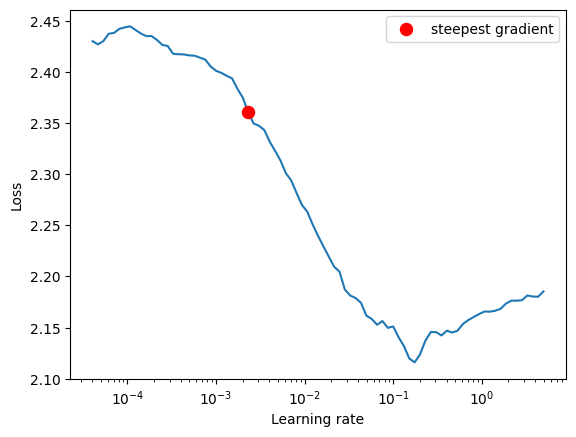

Suggested lr: 0.002310129700083159


In [ ]:
#| notest
device = get_device()

model = ResNet(
    n_channels=[C, 8, 16, 32,16],
    n_classes=10
    ).to(device)

criterion = nn.CrossEntropyLoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #, weight_decay=1e-5)
    
# Initialize LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
    
# Run LR range test
lr_finder.range_test(
    datamodule.train_dataloader(),
    start_lr=1e-5,      # Extremely small starting learning rate
    end_lr=10,          # Large ending learning rate
    num_iter=100,   # Number of iterations to test
    smooth_f=0.05,   # Smoothing factor for the loss
    diverge_th=5, 
)
    
# Plot the learning rate vs loss
_, lr_found = lr_finder.plot(log_lr=True)
print('Suggested lr:', lr_found)
    
lr_finder.reset()
    

size training set: 7575, bs: 64, steps/epoch: 118, total steps: 590
CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 10 μs


[00:05:45] WARNING - Skipping sample at index 3055 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 3602 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 8860 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 6957 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 4886 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 4865 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 6268 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 763 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 2004 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 8728 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 6269 because doesn't have 3 channels
[00:05:45] WARNING - Skipping sample at index 3460 because doesn't have 3 channels
[00:0

Loss 2.5497, Current LR: 0.0002311786, Step: 1/590


[00:05:46] WARNING - Skipping sample at index 3094 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 5886 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 7785 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 8671 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 282 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 6797 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 4715 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 5412 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 9298 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 5090 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 9322 because doesn't have 3 channels
[00:05:46] WARNING - Skipping sample at index 3640 because doesn't have 3 channels
[00:0

Loss 2.1564, Current LR: 0.0015096412, Step: 101/590


[00:05:48] WARNING - Skipping sample at index 9432 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 6756 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 9158 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 9142 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 4412 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 9254 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 4243 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 697 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 3293 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 4728 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 9376 because doesn't have 3 channels
[00:05:48] WARNING - Skipping sample at index 4590 because doesn't have 3 channels
[00:0

Epoch 1: Last training Loss 2.2519, Last Eval loss 1.8470 Accuracy = 33.63% Best Accuracy: 33.71


[00:05:50] WARNING - Skipping sample at index 2341 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 54 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 5361 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 2398 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 4715 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 3969 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 7785 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 7041 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 8654 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 9103 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 7910 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 8938 because doesn't have 3 channels
[00:05

Loss 1.9143, Current LR: 0.0018325990, Step: 120/590


[00:05:50] WARNING - Skipping sample at index 6251 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 143 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 6797 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 9187 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 6957 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 6408 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 9442 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 4136 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 9298 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 9046 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 8621 because doesn't have 3 channels
[00:05:50] WARNING - Skipping sample at index 8221 because doesn't have 3 channels
[00:0

Loss 1.5621, Current LR: 0.0022460355, Step: 220/590


[00:05:52] WARNING - Skipping sample at index 9432 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 9158 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 6756 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 3293 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 9376 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 4243 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 697 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 9142 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 4590 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 4728 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 3152 because doesn't have 3 channels
[00:05:52] WARNING - Skipping sample at index 4412 because doesn't have 3 channels
[00:0

Epoch 2: Last training Loss 1.9657, Last Eval loss 2.1982 Accuracy = 33.69% Best Accuracy: 33.97


[00:05:54] WARNING - Skipping sample at index 2991 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 9058 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 9035 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 4715 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 8860 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 3330 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 6732 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 7461 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 143 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 7041 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 9046 because doesn't have 3 channels
[00:05:54] WARNING - Skipping sample at index 5361 because doesn't have 3 channels
[00:0

Loss 1.7237, Current LR: 0.0021800153, Step: 239/590


[00:05:55] WARNING - Skipping sample at index 750 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 7696 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 8196 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 4768 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 3969 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 8221 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 8944 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 9087 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 2432 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 3460 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 5886 because doesn't have 3 channels
[00:05:55] WARNING - Skipping sample at index 2164 because doesn't have 3 channels
[00:0

Loss 1.6237, Current LR: 0.0015303403, Step: 339/590


[00:05:57] WARNING - Skipping sample at index 6756 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 9158 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 9432 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 9142 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 4243 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 9254 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 3293 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 8696 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 4590 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 9376 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 4412 because doesn't have 3 channels
[00:05:57] WARNING - Skipping sample at index 4728 because doesn't have 3 channels
[00:

Epoch 3: Last training Loss 1.3014, Last Eval loss 1.6538 Accuracy = 48.42% Best Accuracy: 57.81


[00:05:59] WARNING - Skipping sample at index 4768 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 9062 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 6951 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 5361 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 7785 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 9058 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 8658 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 8621 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 5471 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 5468 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 3330 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 4830 because doesn't have 3 channels
[00:

Loss 1.3328, Current LR: 0.0013690948, Step: 358/590


[00:05:59] WARNING - Skipping sample at index 5696 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 3055 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 2341 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 2229 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 4865 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 8571 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 1958 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 2398 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 7910 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 1997 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 4812 because doesn't have 3 channels
[00:05:59] WARNING - Skipping sample at index 7674 because doesn't have 3 channels
[00:

Loss 1.5443, Current LR: 0.0005275867, Step: 458/590


[00:06:01] WARNING - Skipping sample at index 4243 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 9432 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 6756 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 4590 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 9158 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 3293 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 3463 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 4728 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 9376 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 9142 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 697 because doesn't have 3 channels
[00:06:01] WARNING - Skipping sample at index 9254 because doesn't have 3 channels
[00:0

Epoch 4: Last training Loss 1.2427, Last Eval loss 1.5213 Accuracy = 51.27% Best Accuracy: 57.81


[00:06:03] WARNING - Skipping sample at index 6015 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 750 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 1958 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 9461 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 949 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 5882 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 5011 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 7674 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 7857 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 8221 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 8540 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 6672 because doesn't have 3 channels
[00:06

Loss 1.0040, Current LR: 0.0003944607, Step: 477/590


[00:06:03] WARNING - Skipping sample at index 6268 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 6269 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 7387 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 8944 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 9035 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 5414 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 4949 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 6408 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 763 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 9298 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 3415 because doesn't have 3 channels
[00:06:03] WARNING - Skipping sample at index 3045 because doesn't have 3 channels
[00:0

Loss 1.3953, Current LR: 0.0000048319, Step: 577/590
Reached total steps: 590/590


[00:06:05] WARNING - Skipping sample at index 9432 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 3293 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 6756 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 4243 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 9142 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 4728 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 4590 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 9158 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 9254 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 9376 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 3463 because doesn't have 3 channels
[00:06:05] WARNING - Skipping sample at index 9082 because doesn't have 3 channels
[00:

Epoch 5: Last training Loss 1.1929, Last Eval loss 1.4733 Accuracy = 52.59% Best Accuracy: 57.81


[<matplotlib.lines.Line2D>]

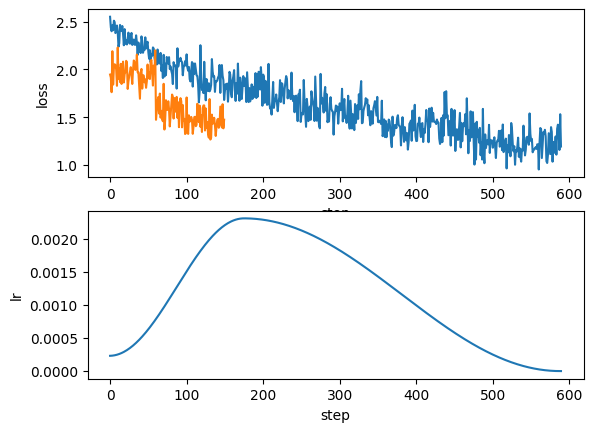

In [ ]:
#| notest

# # data module config
# cfg_dm = OmegaConf.load('../config/data/image/fashion_mnist.yaml')
# cfg_dm.batch_size = 512
# datamodule = instantiate(cfg_dm)
# datamodule.prepare_data()
# datamodule.setup()

# device = 'cpu'
# print(device)
# cfg_mdl = OmegaConf.load('../config/model/image/convnet.yaml')
# convnet = instantiate(cfg_mdl.batchnorm)
# model = convnet.to(device)

N_EPOCHS = 5

# lr_found = 7e-3 # from lr finder

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
steps_per_epoch = len(datamodule.train_ds) // BATCH_SIZE
total_steps = steps_per_epoch* N_EPOCHS
print(f"size training set: {len(datamodule.train_ds)}, bs: {BATCH_SIZE}, steps/epoch: {steps_per_epoch}, total steps: {total_steps}")
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epochs, epochs=1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr_found,  # Peak learning rate
        # total_steps=len(datamodule.train_ds) * N_EPOCHS,  # Total training iterations
        steps_per_epoch=steps_per_epoch,
        epochs=N_EPOCHS,
        pct_start=0.3,  # 30% of training increasing LR, 70% decreasing
        anneal_strategy='cos',  # Cosine annealing
        div_factor=10,  # Initial lr = max_lr / div_factor
        # final_div_factor=1e4,
        three_phase=False  # Two phase LR schedule (increase then decrease)
    )

################################
%time

lrs = []
current_step = 0
train_loss_history = []
eval_loss_history = []
avg_train_loss_hist = []
avg_eval_loss_hist = []
max_acc = 0

for epoch in range(N_EPOCHS):
    i = 0
    model.train()
    for images, labels in datamodule.train_dataloader():
        if current_step >= total_steps:
            print(f"Reached total steps: {current_step}/{total_steps}")
            break
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        scheduler.step()    
        current_step += 1
        train_loss_history.append(loss.item())
        # current_lr = scheduler.get_last_lr()[0]
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        if not (i % 100):
            print(f"Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        i += 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in datamodule.val_dataloader():
            # model expects input (B,H*W)
            images = images.to(device)
            labels = labels.to(device)
            # Pass the input through the model
            outputs = model(images)
            # eval loss
            eval_loss = criterion(outputs, labels)
            eval_loss_history.append(eval_loss.item())
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum()
            acc = 100 * correct / total
            if acc > max_acc:
                max_acc = acc

        # Print the accuracy
    print(f"Epoch {epoch + 1}: Last training Loss {loss.item():.4f}, Last Eval loss {eval_loss.item():.4f} Accuracy = {100 * correct / total:.2f}% Best Accuracy: {max_acc:.2f}")
    # print(f'Current LR: {optimizer.param_groups[0]["lr"]:.5f}')

###################
plt.figure(1)
plt.subplot(211)
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(train_loss_history)
plt.plot(eval_loss_history)
plt.subplot(212)
plt.ylabel('lr')
plt.xlabel('step')
plt.plot(lrs)



## Upsampling

In [ ]:
#| export

class UpSample(nn.Module):
    def __init__(
            self,
            in_channels:int, # Number of input channels
            out_channels:int, # Number of output channels
            scale:int=2, # Scale factor for upsampling
    ):
    
        super().__init__()
        layers = []
        for i in range(int(math.log(scale, 2))):
            layers += [ConvLayer(in_channels, out_channels*4, stride=1, normalization=None, activation=None),nn.PixelShuffle(2)]
        
        self.layers = nn.Sequential(*layers)               


    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.layers(x)

torch.Size([1, 1, 64, 64])


<matplotlib.image.AxesImage>

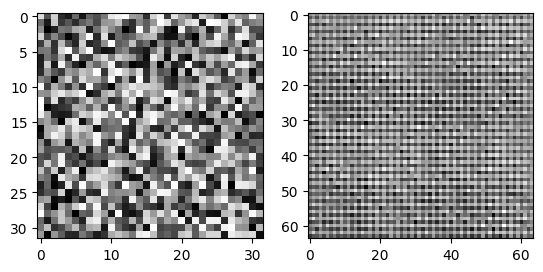

In [ ]:
x = torch.rand(1, 1, 32, 32)
model = UpSample(1, 1)
y = model(x)
print(y.shape)
fig, ax  = plt.subplots(1, 2)
ax[0].imshow(x[0].permute(1, 2, 0), cmap='gray')
ax[1].imshow(y[0].detach().permute(1, 2, 0), cmap='gray')

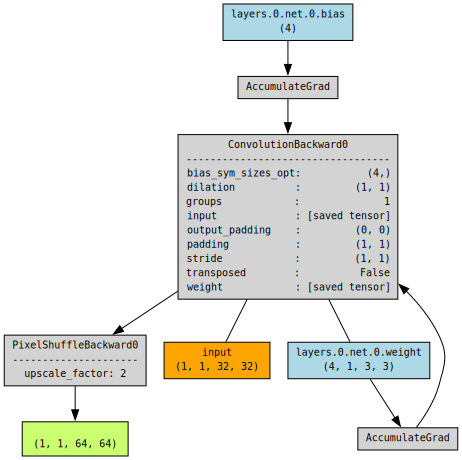

In [ ]:
make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [ ]:
# #| export

# class UpSample(nn.Module):
#     def __init__(
#             self,
#             in_channels:int, # Number of input channels
#             out_channels:int, # Number of output channels
#             scale_factor:int=2 # Upsampling factor
#             ):
#         super().__init__()
#         layers = nn.ModuleList()
#         layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=1))
#         layers.append(nn.Upsample(scale_factor=scale_factor, mode='nearest'))
#         self.layers = nn.Sequential(*layers)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.layers(x)

## Super ResNet

In [ ]:
#| export 

class SuperResNet(nn.Module):
    def __init__(
            self,
            in_channels:int=3, # Number of input channels
            out_channels:int=64, # Number of output channels
            depth:int=8, # Number of residual blocks
            scale:int=2 # Upsampling factor
            ):
        super().__init__()
        layers = []
        conv = partial(ConvLayer, stride=1, normalization=None, activation=None)
        layers.append(conv(in_channels, out_channels))
        for i in range(depth):
            layers.append(ResBlock(out_channels)) 
        layers.append(conv(out_channels, out_channels))
        layers.append(UpSample(out_channels, out_channels, scale))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(conv(out_channels, in_channels))

        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [ ]:
x = torch.rand(1, 3, 32, 32)
model = SuperResNet()
y = model(x)
print(y.shape)

torch.Size([1, 3, 64, 64])


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()